<a href="https://colab.research.google.com/github/FFI-Vietnam/camtrap-tools/blob/main/MegaDetector/confusion_matrix/02_create-confusion-matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
This script evaluates recall accuracy of MegaDetector from a ground-truth dataset
and a result json file. Then it creates a set of visualization of recall values 
on each group of species.

After runnning this script, a 'results' folder is created

results
    |__ 
    
"""

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import requests
import os
from tqdm.notebook import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [166]:
# specifies Colab directories and file names
root = '/content/drive/'

dataset_folder = 'My Drive/FFI/MegaDetector Test/confusion-matrix/dataset'
WI_folder = 'My Drive/FFI/Wildlife Insights Bulk Upload Test/bulk-upload_template-autofill/data cleaning'
contain_folder = 'My Drive/FFI/MegaDetector Test/confusion-matrix/data cleaning'

ground_truth_file_name = '01_ground-truth-table_Kon-Plong.csv'
MD_result_file_name = 'MegaDetector_result_2021-08-27.json'
# taxon match table is generated using Wildlife Insights/bulk-upload/04_collect-WI-taxon-database.ipynb script
# it is saved as 4.1_collect_WI-taxon-database.csv
taxon_match_table_file_name = '4.1_collect_WI-taxon-database.csv'
confusion_matrix_file_name = '02_confusion-matrix.csv'

In [168]:
# read and save file functions
def read_csv_Google_drive(root, contain_folder, file_name):
  file_path = os.path.join(root, contain_folder, file_name)
  return pd.read_csv(file_path)

def save_csv_Google_drive(df, root, contain_folder, file_name, index=False):
  """
  function to save a csv file to Google Drive
  param examples:
    root = '/content/drive/'
    contain_folder = 'My Drive/FFI/dataset'
    file_name = 'image_metadata(2020-06-26)_full.csv'
  """
  # save file to Colab runtime storage (will be deleted when this notebook is closed)
  df.to_csv('dataframe.csv', index=index)

  # save file back to Google Drive for permanent storage
  folder_path = os.path.join(root, contain_folder)
  file_path = os.path.join(root, contain_folder, file_name)
  try:
    os.makedirs(folder_path)
  except:
    pass

  with open('dataframe.csv', 'r') as f:
    df_file = f.read()

  with open(file_path, 'w') as f:
    f.write(df_file)

  print(f'File is saved to {file_name} in Google Drive at {file_path}')

In [57]:
# read ground-truth table
ground_truth_table = read_csv_Google_drive(root, contain_folder, ground_truth_file_name)
id = [i for i in range(len(ground_truth_table))]
ground_truth_table['id'] = id
ground_truth_table[~ ground_truth_table.species_common_name.isna()].head(50)

,FileName,species_common_name,datetime_created,batch_group,id
106498,80__67127__2019-05-04__14-11-25(1).JPG,Grey-shanked Douc Langur,2019-05-04 14:11:25,81914,106498


In [7]:
# read MegaDetector result
result_path = os.path.join(root, dataset_folder, MD_result_file_name)
with open(result_path) as f:
  mega_result = json.load(f)

# print sample result
mega_result['images'][5]

{'detections': [{'bbox': [0.5825, 0.9118, 0.4078, 0.08803],
   'category': '1',
   'conf': 0.849},
  {'bbox': [0.003062, 0.8421, 0.1527, 0.1578],
   'category': '1',
   'conf': 0.214}],
 'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/100/67096/100__67096__2019-04-27__12-50-26(3).JPG',
 'max_detection_conf': 0.849}

In [8]:
# read taxon_match_table
taxon_match_table = read_csv_Google_drive(root, WI_folder, taxon_match_table_file_name)
taxon_match_table.sample(5)

,id,class,order,family,genus,species,authority,commonNameEnglish,taxonomyType,uniqueIdentifier,FFI_species_name
133,2004518,Mammalia,Primates,Cercopithecidae,Pygathrix,cinerea,"Nadler, 1997",Grey-shanked Douc Langur,biological,60ea9d1f-5448-4ec6-ba03-550db94e54e0,Grey-shanked Douc Langur
117,2021317,Mammalia,Rodentia,Sciuridae,NaN,NaN,NaN,Sciuridae Family,biological,e4d1e892-0e4b-475a-a8ac-b5c3502e0d55,Flying squirrel
63,2010435,Aves,Passeriformes,Pittidae,Hydrornis,elliotii,"Oustalet, 1874",Bar-bellied Pitta,biological,4ee5341f-9df0-4187-b134-8ecf24fcbdb3,Bar-bellied Pitta
27,2000328,Mammalia,Rodentia,Hystricidae,Atherurus,macrourus,"Linnaeus, 1758",Asiatic Brush-tailed Porcupine,biological,60d52271-6958-4cc9-be30-57c83d1dc79b,Asiatic Brush-tailed Porcupine
66,2021551,Reptilia,Squamata,NaN,NaN,NaN,NaN,Lizards and Snakes,biological,0af344ad-6657-42c4-85d8-03fd2106a22a,Snake


In [9]:
# sanity check file consistency between MD results and ground-truth data
in_ground_truth_not_MD = []
in_MD_not_ground_truth = []

list_of_MD_filename = []
for i in range(len(mega_result['images'])):
  list_of_MD_filename.append(mega_result['images'][i]['file'].split('/')[-1])

list_of_ground_truth_filename = ground_truth_table['FileName'].to_list()

count_1 = 0
for i in tqdm(range(len(list_of_ground_truth_filename))):
  filename = list_of_ground_truth_filename[i]
  if filename in list_of_MD_filename:
    continue
  count_1 += 1
  in_ground_truth_not_MD.append(filename)

count_2 = 0
for i in tqdm(range(len(mega_result['images']))):
  filename = list_of_MD_filename[i]
  if filename in list_of_ground_truth_filename:
    continue
  count_2 += 1
  in_MD_not_ground_truth.append(filename)

with open('in_ground_truth_not_MD.txt', 'w') as f:
  for i in in_ground_truth_not_MD:
    f.write(i + '\n')
print(f'There are {count_1} files in ground-truth table not found in MegaDetector result. Visit in_ground_truth_not_MD.txt (just created) for details.')

with open('in_MD_not_ground_truth.txt', 'w') as f:
  for i in in_MD_not_ground_truth:
    f.write(i + '\n')
print(f'There are {count_2} files in MegaDetector result not found in ground-truth table. Visit in_MD_not_ground_truth.txt (just created) for details.')


# update ground truth table to contain only files in both
print(f'Ground-truth table original size {len(ground_truth_table)}')
ground_truth_table = ground_truth_table[~ ground_truth_table['FileName'].isin(in_ground_truth_not_MD)]
print(f'Ground-truth table updated size  {len(ground_truth_table)}')

  0%|          | 0/110318 [00:00<?, ?it/s]

  0%|          | 0/110166 [00:00<?, ?it/s]

There are 9243 files in ground-truth table not found in MegaDetector result. Visit in_ground_truth_not_MD.txt (just created) for details.
There are 9174 files in MegaDetector result not found in ground-truth table. Visit in_MD_not_ground_truth.txt (just created) for details.
Ground-truth table original size 110318
Ground-truth table updated size  101075


In [56]:
ground_truth_table[ground_truth_table['species_common_name'] == 'Grey-shanked Douc Langur']

,FileName,species_common_name,datetime_created,batch_group,id
106498,80__67127__2019-05-04__14-11-25(1).JPG,Grey-shanked Douc Langur,2019-05-04 14:11:25,81914,106498


In [123]:
def list_labels(mega_result, ground_truth_table, threshold, in_batch=True):
  """
  list actual labels and prediction labels
  @params in_batch: accounts for images in batch. For example if 3 images in a 
                    batch has 3 animals, but MD could detect only one, that 
                    would be enough to be a correct detection.
  @return: a list of actual labels and a list of predection labels
  """

  def has_any_object_in_batch(detection_batch, threshold, category_id):
    for detection in detection_batch:
      for i in range(len(detection)):
        if detection[i]['conf'] > threshold and detection[i]['category'] == category_id:
          return True
    return False

  print(len(mega_result['images']), "images")
  print('Generating actual and prediction lists...')

  # get list of files
  list_of_MD_filename = []
  for i in range(len(mega_result['images'])):
    list_of_MD_filename.append(mega_result['images'][i]['file'].split('/')[-1])

  category = {
      '1': 'Animal',
      '2': 'Human',
      '3': 'Vehicle'
  }

  # get number of batches
  # num_batch = ground_truth_table['batch_group'].nunique()

  y_actu = []
  y_pred = []

  if in_batch:
    # num_row = num_batch
    search_range = ground_truth_table['batch_group'].unique()
    column_name = 'batch_group'
  else:
    # num_row = len(ground_truth_table)
    search_range = ground_truth_table['id'].unique()
    column_name = 'id'

  """
  treat each batch as an image
  # in case batch is blank
  if all rows are blank:
    if all predictions are blank:
      actu.append('Blank')
      pred.append('Blank')
    if there is at least one animal in predictions:
      actu.append('Blank')
      pred.append('Animal')

  # in case batch is not blank
  if there are n distinct animals, e.g. Human and Domestic Dog:
    for each distinct animal
      if any of that animal is correctly detected:
        actu.append(distinct_animal)
        pred.append(animal)
      else:
        actu.append(distinct_animal)
        pred.append('Blank')
  """
  for i in tqdm(range(len(search_range))):
    sub_table = ground_truth_table[ground_truth_table[column_name] == search_range[i]]

    filenames = sub_table['FileName'].to_list()

    # store list of detections for the batch
    detection_batch = []

    for f in filenames:
      try:
        detection = mega_result['images'][list_of_MD_filename.index(f)]['detections']
        detection_batch.append(detection)
      except Exception as e:
        # print(str(e))
        print(mega_result['images'][list_of_MD_filename.index(f)])

    # if all images are blank
    if sub_table['species_common_name'].isnull().sum() == len(sub_table):
      # if any Human is detected
      if has_any_object_in_batch(detection_batch, threshold, '2'):
        y_actu.append('Blank')
        y_pred.append('Human')
      # if any Animal is detected
      elif has_any_object_in_batch(detection_batch, threshold, '1'):
        y_actu.append('Blank')
        y_pred.append('Animal')
      else:
        y_actu.append('Blank')
        y_pred.append('Blank')

    # if there is at least one detection event
    else:
      # list n distinct animal detections
      distinct_animals = sub_table[sub_table['species_common_name'].notnull()]['species_common_name'].unique()

      for animal in distinct_animals:
        
        if animal == 'Human':
          if has_any_object_in_batch(detection_batch, threshold, '2'):
            y_actu.append('Human')
            y_pred.append('Human')
          elif has_any_object_in_batch(detection_batch, threshold, '1'):
            y_actu.append('Human')
            y_pred.append('Animal')
          else:
            y_actu.append('Human')
            y_pred.append('Blank')
        else:
          if has_any_object_in_batch(detection_batch, threshold, '2'):
            y_actu.append(animal)
            y_pred.append('Human')
          elif has_any_object_in_batch(detection_batch, threshold, '1'):
            y_actu.append(animal)
            y_pred.append(animal)
          else:
            y_actu.append(animal)
            y_pred.append('Blank')

  y_pr = np.array(y_pred)
  print('Reduction rate', len(y_pr[y_pr == 'Blank']) / len(y_pr))
  return y_actu, y_pred

y_actu_test, y_pred_test = list_labels(mega_result, ground_truth_table, 0.5, in_batch=True)

110166 images
Generating actual and prediction lists...


  0%|          | 0/79939 [00:00<?, ?it/s]

{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__01-21-58(2)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__01-22-20(1)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-44-39(2)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-44-59(3)__Blank.JPG', 'failure': 'Failure image access'}
{'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/332/68986/kpc332__ct68986__2019-11-04__04-45-21(1)__Blank.JPG', 'failure': 'Failure image access'}


In [100]:
# sanity check y_actu and y_pred lists

y_actu = pd.Series(y_actu_test)
y_pred = pd.Series(y_pred_test)

# Test 01: number of images
in_batch = True
if in_batch:
  count = 0
  for i in ground_truth_table['batch_group'].unique():
    sub_table = ground_truth_table[ground_truth_table['batch_group'] == i]
    count += sub_table[sub_table['species_common_name'].notnull()]['species_common_name'].nunique()
else:
  count = len(ground_truth_table)
if (y_actu!='Blank').sum() == count:
  print('Pass test 01')
else:
  print('Failed test 01: Has', (y_actu!='Blank').sum(), 'but expects', count)

Failed test 01: Has 20588 but expects 22017


In [126]:
y_actu[y_actu == 'Grey-shanked Douc Langur']
# (y_actu!='Blank').sum()

77146    Grey-shanked Douc Langur
dtype: object

In [124]:
y_actu = pd.Series(y_actu_test)
y_pred = pd.Series(y_pred_test)

In [ ]:
#@title temporary hidden
def list_labels(mega_result, ground_truth_table, THRESHOLD):
  """
  list actual labels and prediction labels
  """

  def has_object(detections, threshold, category_id):
    for i in range(len(detections)):
      if detections[i]['conf'] > threshold and detections[i]['category'] == category_id:
        return True
    return False

  print(len(mega_result['images']), "images")
  print('Generating actual and prediction lists...')

  # get list of files
  files = []
  for i in range(len(mega_result['images'])):
    files.append(mega_result['images'][i]['file'].split('/')[-1])

  category = {
      '1': 'Animal',
      '2': 'Human',
      '3': 'Vehicle'
  }

  y_actu = []
  y_pred = []

  count = 0

  for i in tqdm(range(len(ground_truth_table))):
    try:
      # actual label
      actu = ground_truth_table['species_common_name'].iat[i]

      filename = ground_truth_table['FileName'].iat[i]

      # prediction label

      # if the image has any human
      if has_object(mega_result['images'][files.index(filename)]['detections'], THRESHOLD, '2'):
        y_pred.append('Human')
        if str(actu) == 'nan':
          y_actu.append('Blank')
        else:
          y_actu.append(actu)
      # if the image has any animal
      elif has_object(mega_result['images'][files.index(filename)]['detections'], THRESHOLD, '1'):
        if str(actu) == 'nan':
          y_pred.append('Animal')
          y_actu.append('Blank')
        else:
          y_pred.append(actu)
          y_actu.append(actu)

      # if not have any human or animal
      elif (not has_object(mega_result['images'][files.index(filename)]['detections'], THRESHOLD, '1')) and (not has_object(mega_result['images'][files.index(filename)]['detections'], THRESHOLD, '2')):
        y_pred.append('Blank')
        if str(actu) == 'nan':
          y_actu.append('Blank')
        else:
          y_actu.append(actu)    
    except Exception as e:
      count += 1
      # print(str(e))
      pass
  print(count)
  y_pr = np.array(y_pred)
  print('Reduction rate', len(y_pr[y_pr == 'Blank']) / len(y_pr))
  return y_actu, y_pred


y_actu_ground, y_pred_ground = list_labels(mega_result, ground_truth_table, 0.5)

110166 images
Generating actual and prediction lists...


  0%|          | 0/110318 [00:00<?, ?it/s]

9263
Reduction rate 0.7793676710702093


In [ ]:
print('ground', len(y_actu_ground))
print('test  ', len(y_actu_test))

print('ground', len(y_pred_ground))
print('test  ', len(y_pred_test))

print(y_actu_test == y_actu_ground)

for i in range(len(y_pred_test)):
  if y_pred_test[i] != y_pred_ground[i]:

    print(y_pred_test[i], y_pred_ground[i])

# pd.DataFrame({'y_actu_ground':y_actu_ground, 'y_actu_test': y_actu_test})
# pd.DataFrame({'y_pred_ground':y_pred_ground, 'y_pred_test': y_pred_test}).to_csv('prediction.csv')

ground 101055
test   101055
ground 101055
test   101055


In [11]:
def get_taxonomy(species_common_name, level, taxon_match_table):
  """
  get taxonomical class level of a species
  """
  row = taxon_match_table[taxon_match_table['FFI_species_name'] == species_common_name]
  try:
    taxon_class = row[level.lower()].iat[0]
  except:
    print('     Can not find taxonomy info for', species_common_name)
  return taxon_class

# test
get_taxonomy('Annamite Dark Muntjac', 'family', taxon_match_table)

'Cervidae'

In [30]:
name = "Human"
taxon_match_table[taxon_match_table['FFI_species_name'] == name]

,id,class,order,family,genus,species,authority,commonNameEnglish,taxonomyType,uniqueIdentifier,FFI_species_name
0,2002045,Mammalia,Primates,Hominidae,Homo,sapiens,"Linnaeus, 1758",Human,biological,990ae9dd-7a59-4344-afcb-1b7b21368000,Human


In [13]:
def get_scientific_name(species_common_name, taxon_match_table):
  """
  get genus and species name of a species
  """
  row = taxon_match_table[taxon_match_table['FFI_species_name'] == species_common_name]
  try:
    genus, species = row['genus'].iat[0], row['species'].iat[0]
  except:
    print('     Can not find taxonomy info for', species_common_name)
  return genus, species

# test
get_scientific_name("Owston's Civet", taxon_match_table)

('Chrotogale', 'owstoni')

In [14]:
def get_conservation_status(genus, species):
  """
  get consevation status of a species from IUCN red list API
  https://apiv3.iucnredlist.org/api/v3/docs#species-history-name
  """
  api_token = "eba8c1a83a9d25e8ff01b8acbfa153fe3317d90badd60e2ec1d87ac8b330fda6"
  response = requests.get(f"https://apiv3.iucnredlist.org/api/v3/species/history/name/{genus}%20{species}?token={api_token}")
  try:
    status = response.json()['result'][0]['category']
  except:
    print('     Can not find conservation status for', genus, species)
  return status

# test
get_conservation_status('Chrotogale', 'owstoni')

'Endangered'

In [172]:
def create_confusion_matrix(y_actu, y_pred):
  print('Generating confusion matrix...')

  y_actu = pd.Series(y_actu, name='Actual')
  y_pred = pd.Series(y_pred, name='Prediction')
  df_confusion = pd.crosstab(y_pred, y_actu, rownames=['Prediction'], colnames=['Actual'], margins=True)
  
  # collapse rows
  confusion_matrix = pd.DataFrame(index = ['Animal', 'Human', 'Blank', 'Total', 'Recall'])
  for col in df_confusion.columns:
    all = df_confusion[col]['All']
    animal = all - df_confusion[col]['Blank'] - df_confusion[col]['Human']
    human = df_confusion[col]['Human']
    blank = df_confusion[col]['Blank']
    total = animal + human + blank
    confusion_matrix[col] = [animal, human, blank, total, 0] # leave a blank cell for recall value
  
  # lump the Murid rodent family
  confusion_matrix['Murid'] = confusion_matrix['Murid'] + confusion_matrix['Leopoldamys'] + confusion_matrix['Maxomys']

  # drop columns 
  confusion_matrix.drop(columns=['Moth', 'Bat', 'Flying Insect', 'Leopoldamys', 'Maxomys', 'Butterfly'], inplace=True)
  
  # cast from int to float to save recall value
  confusion_matrix = confusion_matrix.astype('float')

  # add recall row
  for col in confusion_matrix.columns:
    if col == 'Blank':
      confusion_matrix[col][4] = round(int(confusion_matrix[col][2]) / int(confusion_matrix[col][3]), 2)
    elif col == 'Human':
      confusion_matrix[col][4] = round(int(confusion_matrix[col][1]) / int(confusion_matrix[col][3]), 2)
    else:
      confusion_matrix[col][4] = round(int(confusion_matrix[col][0]) / int(confusion_matrix[col][3]), 2)

  return confusion_matrix

confusion_matrix = create_confusion_matrix(y_actu_test, y_pred_test)


Generating confusion matrix...


In [160]:
def find_FFI_species_by_taxonomy(taxon_match_table, level, taxonomy):
  """
  returns list of species in a taxonomical group, e.g. class Mammalia, order Rodentia
  """
  sub_df = taxon_match_table[taxon_match_table[level.lower()] == taxonomy]
  
  return sub_df['FFI_species_name'].to_list() 

In [173]:
confusion_matrix[list(set(find_FFI_species_by_taxonomy(taxon_match_table, 'order', 'Rodentia')) & set(confusion_matrix.columns))]

,Malayan Porcupine,Asiatic Brush-tailed Porcupine,Particolored Flying Squirrel,Eastern Striped Squirrel,Flying squirrel,Asian Red-cheeked Squirrel,Pallas's Squirrel,Murid,Squirrel,Black Giant Squirrel,Hoary Bamboo Rat,Indian Giant Flying Squirrel
Animal,7.00,65.00,3.0,2.00,2.00,301.00,206.00,3148.00,216.00,5.00,3.0,1.0
Human,0.00,0.00,0.0,0.00,0.00,0.00,0.00,1.00,4.00,0.00,0.0,0.0
Blank,2.00,82.00,2.0,9.00,7.00,227.00,101.00,5013.00,521.00,1.00,0.0,0.0
Total,9.00,147.00,5.0,11.00,9.00,528.00,307.00,8162.00,741.00,6.00,3.0,1.0
Recall,0.78,0.44,0.6,0.18,0.22,0.57,0.67,0.39,0.29,0.83,1.0,1.0


In [203]:
def create_confusion_matrix_by_group(confusion_matrix, species_group):
  """
  create a confusion matrix by species group, e.g. "ungulates", "small carnivores", "birds", "small mammals (squirrels and rats)", "primates"
  @params species_group: dict {group_common_name: [toxonomical_level, group_scientific_name, except]}
    example: {'Bird':["class", "Aves", []], "Small carnivores":["order", "Carnivora", ["Asian Black Bear"]]}
  """
  confusion_matrix_by_group = pd.DataFrame(index = ['Animal', 'Human', 'Blank', 'Total', 'Recall'])
  for group in species_group.keys():
    species_list = find_FFI_species_by_taxonomy(taxon_match_table, 
                                                species_group[group][0], 
                                                species_group[group][1])
    # remove except species, e.g. Asian Black Bear not in Small Carnivores
    species_list = list(set(species_list) - set(species_group[group][2]))
    # remove unnecessary species such as Bat, Maxomys, etc
    species_list = list(set(species_list) & set(confusion_matrix.columns))
    # lump into one group
    confusion_matrix_by_group[group] = confusion_matrix[species_list].astype('float').sum(axis = 1) # cast to int to avoid weird behaviors!

  # update recall
  for col in confusion_matrix_by_group.columns:
    if col == 'Human':
      confusion_matrix_by_group[col][4] = round(int(confusion_matrix_by_group[col][1]) / int(confusion_matrix_by_group[col][3]), 2)
    else:
      confusion_matrix_by_group[col][4] = round(int(confusion_matrix_by_group[col][0]) / int(confusion_matrix_by_group[col][3]), 2)
  return confusion_matrix_by_group

confusion_matrix_by_group = \
create_confusion_matrix_by_group(confusion_matrix, {'Ungulates'       :['order', 'Cetartiodactyla', []],
                                                    'Birds'           :['class', 'Aves', []],
                                                    'Small carnivores':['order', 'Carnivora', ["Asian Black Bear"]],
                                                    'Small mammals'   :['order', 'Rodentia', []],
                                                    'Primates'        :['order', 'Primates', ['Human']],
                                                    'Bear'            :['family', 'Ursidae', []],
                                                    'Pangolin'        :['family', 'Manidae', []],
                                                    'Human'           :['species', 'sapiens', []]
                                                    })

In [209]:
confusion_matrix_by_group

,Ungulates,Birds,Small carnivores,Small mammals,Primates,Bear,Pangolin,Human
Animal,324.00,3349.0,1949.00,3959.0,341.00,9.0,5.0,92.00
Human,0.00,17.0,17.00,5.0,0.00,0.0,0.0,1123.00
Blank,71.00,2244.0,928.00,5965.0,129.00,1.0,0.0,411.00
Total,395.00,5610.0,2894.00,9929.0,470.00,10.0,5.0,1626.00
Recall,0.82,0.6,0.67,0.4,0.73,0.9,1.0,0.69


In [174]:
save_csv_Google_drive(confusion_matrix, root, contain_folder, confusion_matrix_file_name, index=True)

File is saved to 02_confusion-matrix.csv in Google Drive at /content/drive/My Drive/FFI/MegaDetector Test/confusion-matrix/data cleaning/02_confusion-matrix.csv


In [212]:
def visualize_recall_bargraph(group_name, confusion_matrix, threshold, color_list, num_image_threshold=0, legend_by_color=False, custom_size=False):
  """
  visualize recall values by bargraph by taxonomical class
  """

  print(f"Generating visualization plot for {group_name}...")
  total = []
  recall = []
  names = []
  colors = []

  image_count = len(mega_result['images'])

  data = confusion_matrix

  species_list = data.columns.to_list()
  for species in species_list:
    # try:
    if data[species]['Total'] >= num_image_threshold:
      recall.append(data[species]['Recall'])
      total.append(data[species]['Total'])
      names.append((species))
      colors.append(color_list[species_list.index(species)])
    # except:
      # pass

  recall_stats = pd.DataFrame({'name':names, 'recall':recall, 'total':total})
  recall_stats['recall'] = recall_stats['recall'].astype('float64')
  recall_stats['total'] = recall_stats['total'].astype('int')
  recall_stats.sort_values('recall', inplace=True, ascending=True)

  # creating the bar plot
  species_name = recall_stats['name'].to_list()
  values = recall_stats['recall'].to_list()
  total = recall_stats['total'].to_list()
  avg_recall = np.mean(recall_stats['recall'])

  if custom_size:
    fig = plt.figure(figsize=(10, 20))
    
  plt.barh(species_name, values, color=colors)
  for i, v in enumerate(values):
      plt.text(v, i, str(round(v,2)), color='blue', fontweight='bold')
      plt.text(v+0.1, i, f'{str(total[i])} images', color='blue', fontweight='bold')
  # for i, v in enumerate(total):

  plt.xlabel("Values")
  plt.ylabel("Species name")
  labels = list(color_map.keys())
  if legend_by_color:
    handles = [plt.Rectangle((0,0),1,1, color=color_map[label]) for label in labels]
    plt.legend(handles, labels)
  plt.title(f"Evaluate over {image_count} images for {group_name}" +
            f"\nminimum image amount: {num_image_threshold}" +
            f"\nthreshold:  {threshold}" +
            f"\naverage_recall_value: {round(avg_recall,2)}")
  plt.show()


In [215]:
# all species
colors = []
color_map = {
              "Not Evaluated": "lightblue",
              "Data Deficient": "lightyellow",
              "Least Concern": "mediumseagreen",
              "Near Threatened": "olive",
              "Vulnerable": "orange",
              "Endangered": "orangered",
              "Critically Endangered": "maroon",
              "Extinct in the Wild": "black",
              "Extinct": "dimgrey",
              "Not applicable": "lightgrey"
            }
for name in confusion_matrix.columns:
  try:
    genus, species = get_scientific_name(name, taxon_match_table)
    status = get_conservation_status(genus, species)
    colors.append(color_map[status])
  except:
    colors.append(color_map["Not applicable"])

     Can not find conservation status for nan nan
     Can not find taxonomy info for Banded Krait
     Can not find conservation status for nan nan
     Can not find taxonomy info for Black-throated Laughingthrush
     Can not find conservation status for nan nan
     Can not find conservation status for Bubalus nan
     Can not find conservation status for Canis familiaris
     Can not find conservation status for Sus scrofa scrofa
     Can not find conservation status for Melogale nan
     Can not find conservation status for nan nan
     Can not find conservation status for Homo sapiens
     Can not find taxonomy info for Impressed Tortoise
     Can not find conservation status for Macaca nan
     Can not find conservation status for nan nan
     Can not find conservation status for Muntiacus nan
     Can not find conservation status for nan nan
     Can not find conservation status for nan nan
     Can not find conservation status for nan nan
     Can not find conservation status 

Generating visualization plot for All species...


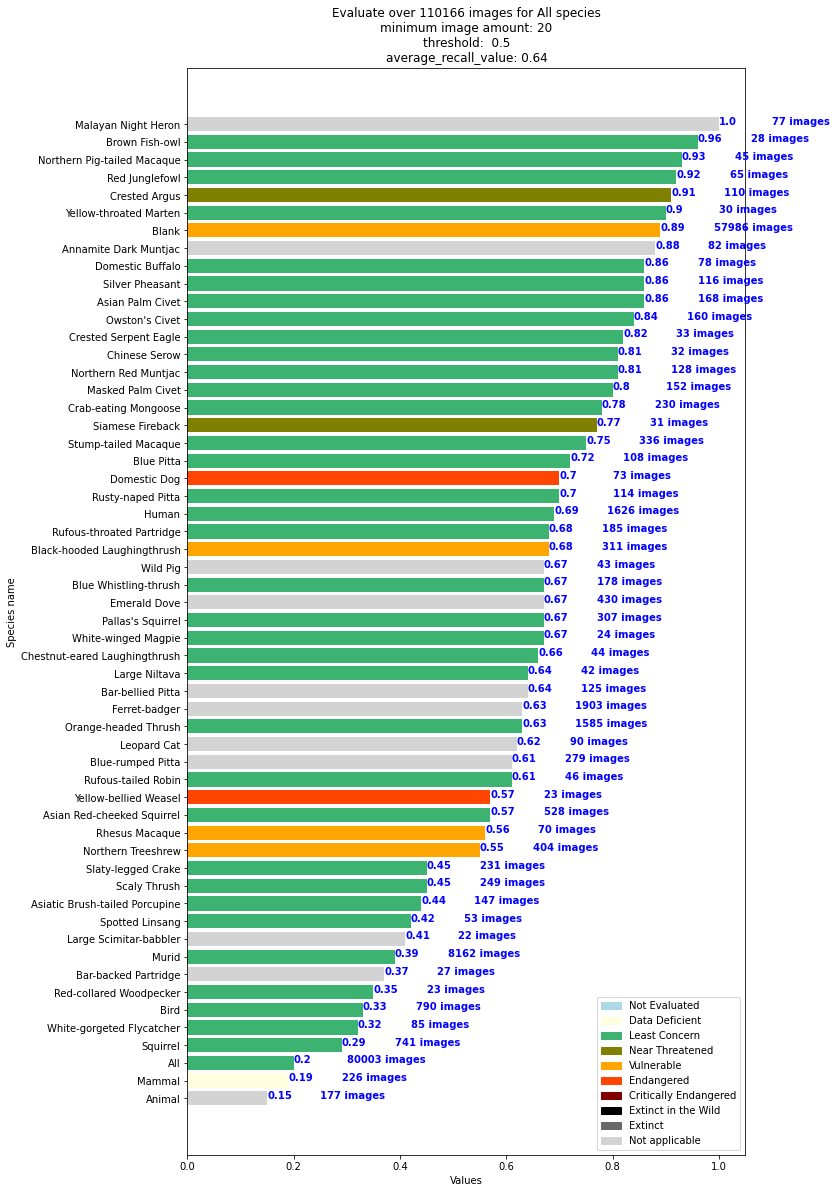

In [216]:
visualize_recall_bargraph('All species', confusion_matrix, threshold=0.5, color_list = colors, num_image_threshold=20, legend_by_color=True, custom_size=True)

Generating visualization plot for Large groups...


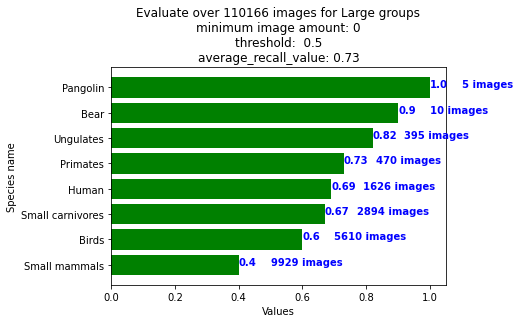

In [213]:
# in large group
visualize_recall_bargraph('Large groups', confusion_matrix_by_group, threshold=0.5, color_list = ['green' for i in range(len(confusion_matrix_by_group.columns))], legend_by_color=False)

In [ ]:
# in rare group


In [ ]:
def recall_evaluation(THRESHOLD, taxon_class, ground_truth_table, mega_result, taxon_match_table, in_batch):
  y_actu, y_pred = list_labels(mega_result, ground_truth_table, THRESHOLD, in_batch)
  confusion_matrix = create_confusion_matrix(y_actu, y_pred)
  visualize_recall_bargraph(taxon_class, confusion_matrix, THRESHOLD, taxon_match_table, 20)

110166 images
Generating actual and prediction lists...


  0%|          | 0/85410 [00:00<?, ?it/s]

['100__68952__2019-04-23__14-23-19(1).JPG', '100__68952__2019-04-23__14-23-19(1).JPG']
['100__68952__2019-04-23__14-23-19(1).JPG', '100__68952__2019-04-23__14-23-19(1).JPG']
['100__68952__2019-04-23__14-23-38(2).JPG', '100__68952__2019-04-23__14-23-38(2).JPG']
['100__68952__2019-04-23__14-23-38(2).JPG', '100__68952__2019-04-23__14-23-38(2).JPG']
['100__68952__2019-04-23__14-23-59(3).JPG', '100__68952__2019-04-23__14-23-59(3).JPG']
['100__68952__2019-04-23__14-23-59(3).JPG', '100__68952__2019-04-23__14-23-59(3).JPG']
['100__68952__2019-04-24__13-05-02(1).JPG', '100__68952__2019-04-24__13-05-02(1).JPG', '100__68952__2019-04-24__13-05-03(2).JPG', '100__68952__2019-04-24__13-05-03(2).JPG', '100__68952__2019-04-24__13-05-05(3).JPG', '100__68952__2019-04-24__13-05-05(3).JPG']
['100__68952__2019-04-24__13-05-02(1).JPG', '100__68952__2019-04-24__13-05-02(1).JPG', '100__68952__2019-04-24__13-05-03(2).JPG', '100__68952__2019-04-24__13-05-03(2).JPG', '100__68952__2019-04-24__13-05-05(3).JPG', '10

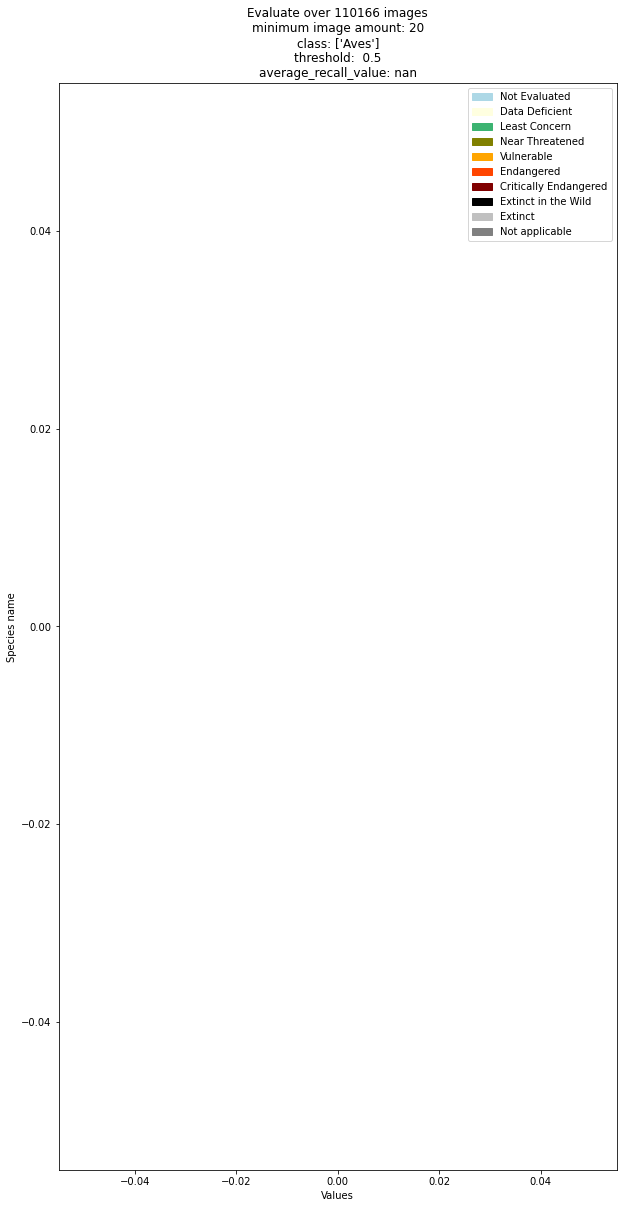

In [ ]:
# read files
ground_truth_table = read_csv_Google_drive(root, ground_truth_folder, ground_truth_file_name)
taxon_match_table = read_csv_Google_drive(root, WI_folder, taxon_match_table_file_name)
result_path = os.path.join(root, dataset_folder, MD_result_file_name)
with open(result_path) as f:
  mega_result = json.load(f)

recall_evaluation(0.5, ['Aves'], ground_truth_table, mega_result, taxon_match_table, in_batch=True)

110166 images
Generating actual and prediction lists...
Reduction rate 0.7772391117605821
Generating confusion matrix...
Generating visualization plot for ['Mammalia', 'Insecta', 'Reptilia']...
     Can not find taxonomy info for Animal
     Can not find taxonomy info for Banded Krait
     Can not find taxonomy info for Black-throated Laughingthrush
     Can not find taxonomy info for Flying Insect
     Can not find taxonomy info for Hill Blue Flycatcher
     Can not find taxonomy info for Impressed Tortoise
     Can not find taxonomy info for Indochinese Wren-babbler
     Can not find taxonomy info for Small Asian Mongoose
     Can not find conservation status for nan nan
     Can not find conservation status for nan nan
     Can not find conservation status for nan nan
     Can not find conservation status for nan nan
     Can not find conservation status for nan nan
     Can not find conservation status for nan nan
     Can not find conservation status for Macaca nan
     Can not fi

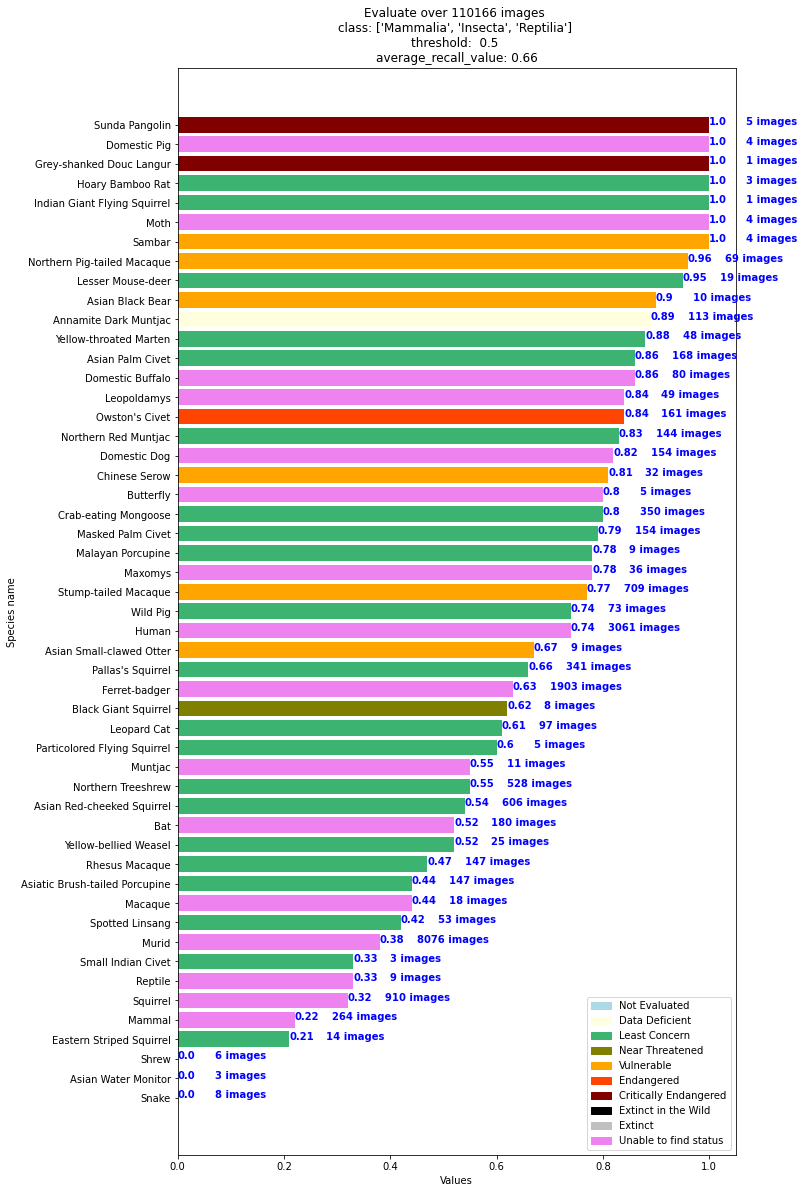

In [ ]:
recall_evaluation(0.5, ['Mammalia', 'Insecta', 'Reptilia'])